In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
import numpy as np
from src.eventstream import Eventstream, RawDataSchema
from src import datasets
test_stream: Eventstream = datasets.load_simple_shop()

/home/akorovko/retentioneering-tools-new-arch/examples/../src/params_model/params_model.py:68: UserWarning: Callable filter was excluded from schema since JSON schema has no equivalent type.
  params_schema: dict[str, Any] = cls.schema()
/home/akorovko/retentioneering-tools-new-arch/examples/../src/params_model/params_model.py:68: UserWarning: Callable negative_function was excluded from schema since JSON schema has no equivalent type.
  params_schema: dict[str, Any] = cls.schema()
/home/akorovko/retentioneering-tools-new-arch/examples/../src/params_model/params_model.py:68: UserWarning: Callable positive_function was excluded from schema since JSON schema has no equivalent type.
  params_schema: dict[str, Any] = cls.schema()


In [3]:
df = test_stream.to_dataframe()
df

,event_id,event_type,event_index,event_name,event_timestamp,user_id
0,83f236c4-f811-4fc0-b92f-d7a9c57ff0d2,raw,0,catalog,2019-11-01 17:59:13.273932,219483890
1,e774d58f-d636-472f-9168-bf365cecb5fa,raw,1,product1,2019-11-01 17:59:28.459271,219483890
2,1d91c9ea-9fdd-4d8f-91b8-c9496bae89c0,raw,2,cart,2019-11-01 17:59:29.502214,219483890
3,6a39ce9c-c823-4196-9b74-aeec8c20acf8,raw,3,catalog,2019-11-01 17:59:32.557029,219483890
4,8728dc61-dec9-438e-afa5-d75f5228077a,raw,4,catalog,2019-11-01 21:38:19.283663,964964743
...,...,...,...,...,...,...
35376,d7d60ab2-871c-4841-a02e-d36d60d55d79,raw,35376,catalog,2020-04-29 12:47:40.975732,501098384
35377,6213c8ce-5666-4d52-b455-72b81681a7e2,raw,35377,catalog,2020-04-29 12:48:01.809577,501098384
35378,05f212e3-c437-42be-9f64-263a99823f18,raw,35378,main,2020-04-29 12:48:01.938488,501098384
35379,914669d1-3470-4dce-996b-17939d8646b5,raw,35379,catalog,2020-04-29 12:48:06.595390,501098384


In [4]:
df['event_name'].value_counts()

catalog             14518
main                 5635
lost                 3098
cart                 2842
product2             2172
delivery_choice      1686
product1             1515
payment_choice       1107
delivery_courier      834
payment_done          706
payment_card          565
delivery_pickup       506
payment_cash          197
Name: event_name, dtype: int64

In [5]:
users_by_event_cnt = df.groupby('user_id')['event_id'].nunique().sort_values(ascending=False)
users_by_event_cnt

user_id
530349536    100
962952209     94
898482504     92
78179456      83
760510988     83
            ... 
877370577      2
467642580      2
467897940      2
471297425      2
999941967      2
Name: event_id, Length: 3751, dtype: int64

In [6]:
most_active = users_by_event_cnt.index[:int(users_by_event_cnt.shape[0]/2)].values
least_active = users_by_event_cnt.index.values[~np.isin(users_by_event_cnt.index.values, most_active)]

In [7]:
most_active.shape

(1875,)

In [8]:
least_active.shape

(1876,)

Let us check whether the most active 50% of users are significantly more active than the least active 50%:

{'group_one_name': 'most_active',
 'group_one_size': 1875,
 'group_one_mean': 14.8608,
 'group_one_SD': 9.910012951219255,
 'group_two_name': 'least_active',
 'group_two_size': 1876,
 'group_two_mean': 4.006929637526652,
 'group_two_SD': 1.6169593451394413,
 'greatest_group_name': 'least_active',
 'is_group_one_greatest': False,
 'p_val': 0.0,
 'power_estimated': 1.0}

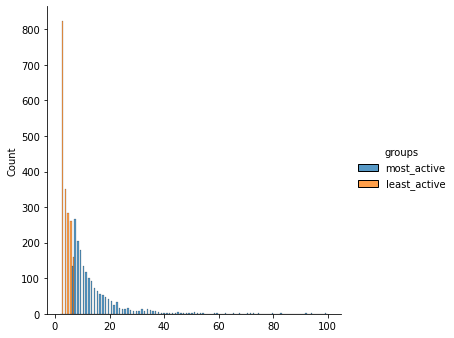

In [9]:
test_stream.unpaired_group_test(groups=(most_active, least_active),
                                function=lambda x: x.shape[0],
                                group_names=('most_active', 'least_active'),
                                test='ttest')

Same but for "payment_done" indicator:

{'group_one_name': 'most_active',
 'group_one_size': 1875,
 'group_one_mean': 0.32426666666666665,
 'group_one_SD': 0.4681001982007223,
 'group_two_name': 'least_active',
 'group_two_size': 1876,
 'group_two_mean': 0.02398720682302772,
 'group_two_SD': 0.1530092178002914,
 'greatest_group_name': 'least_active',
 'is_group_one_greatest': False,
 'p_val': 2.4651106608514452e-141,
 'power_estimated': 1.0}

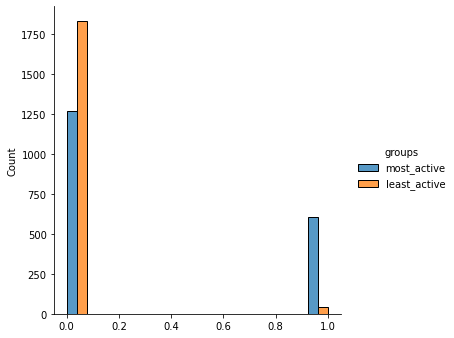

In [11]:
test_stream.unpaired_group_test(groups=(most_active, least_active),
                                function=lambda x: 'payment_done' in x['event_name'].values,
                                group_names=('most_active', 'least_active'),
                                test='ttest')

In [12]:
test_stream.unpaired_group_test(groups=(most_active, least_active),
                                function=lambda x: 'payment_done' in x['event_name'].values,
                                group_names=('most_active', 'least_active'),
                                test='chi2_contingency',
                                plot_groups=False)

{'group_one_name': 'most_active',
 'group_one_size': 1875,
 'group_one_mean': 0.32426666666666665,
 'group_one_SD': 0.4681001982007223,
 'group_two_name': 'least_active',
 'group_two_size': 1876,
 'group_two_mean': 0.02398720682302772,
 'group_two_SD': 0.1530092178002914,
 'greatest_group_name': 'most_active',
 'is_group_one_greatest': True,
 'p_val': 1.8620370399069264e-129}

In [13]:
test_stream.unpaired_group_test(groups=(most_active, least_active),
                                function=lambda x: 'payment_done' in x['event_name'].values,
                                group_names=('most_active', 'least_active'),
                                test='fisher_exact',
                                plot_groups=False)

{'group_one_name': 'most_active',
 'group_one_size': 1875,
 'group_one_mean': 0.32426666666666665,
 'group_one_SD': 0.4681001982007223,
 'group_two_name': 'least_active',
 'group_two_size': 1876,
 'group_two_mean': 0.02398720682302772,
 'group_two_SD': 0.1530092178002914,
 'greatest_group_name': 'most_active',
 'is_group_one_greatest': True,
 'p_val': 9.940202050326225e-150}

Same but for first 50% chronologically vs the rest:

In [14]:
users_by_appearance = df.groupby('user_id')['event_timestamp'].min().sort_values()
first_half = users_by_appearance.index[:int(users_by_event_cnt.shape[0]/2)].values
second_half = users_by_appearance.index.values[~np.isin(users_by_appearance.index.values, most_active)]

test_stream.unpaired_group_test(groups=(first_half, second_half),
                                function=lambda x: 'payment_done' in x['event_name'].values,
                                group_names=('most_active', 'least_active'),
                                test='mannwhitneyu',
                                plot_groups=False)

{'group_one_name': 'most_active',
 'group_one_size': 1875,
 'group_one_mean': 0.17973333333333333,
 'group_one_SD': 0.3839651836068242,
 'group_two_name': 'least_active',
 'group_two_size': 1876,
 'group_two_mean': 0.02398720682302772,
 'group_two_SD': 0.1530092178002914,
 'greatest_group_name': 'least_active',
 'is_group_one_greatest': False,
 'p_val': 2.597361243028909e-56,
 'power_estimated': 1.0}

Same but for random 50%:

{'group_one_name': 'most_active',
 'group_one_size': 1875,
 'group_one_mean': 0.17333333333333334,
 'group_one_SD': 0.37853518844209044,
 'group_two_name': 'least_active',
 'group_two_size': 1876,
 'group_two_mean': 0.17484008528784648,
 'group_two_SD': 0.37983026454507945,
 'greatest_group_name': 'most_active',
 'is_group_one_greatest': True,
 'p_val': 0.9373315220781995}

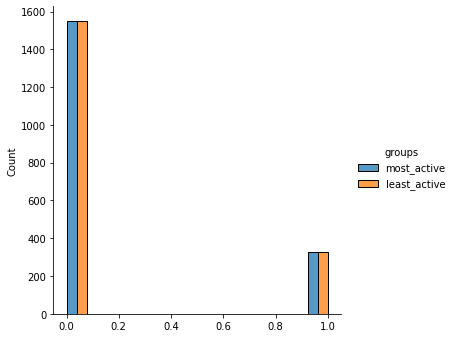

In [15]:
users = df['user_id'].unique()
np.random.seed(962)
first_half = np.random.choice(users, int(users.shape[0]/2), replace=False)
second_half = users[~np.isin(users, first_half)]

test_stream.unpaired_group_test(groups=(first_half, second_half),
                                function=lambda x: 'payment_done' in x['event_name'].values,
                                group_names=('most_active', 'least_active'),
                                test='chi2_contingency',
                                plot_groups=True)

{'group_one_name': 'most_active',
 'group_one_size': 1875,
 'group_one_mean': 0.17333333333333334,
 'group_one_SD': 0.37853518844209044,
 'group_two_name': 'least_active',
 'group_two_size': 1876,
 'group_two_mean': 0.17484008528784648,
 'group_two_SD': 0.37983026454507945,
 'greatest_group_name': 'least_active',
 'is_group_one_greatest': False,
 'p_val': 0.4686694861258803}

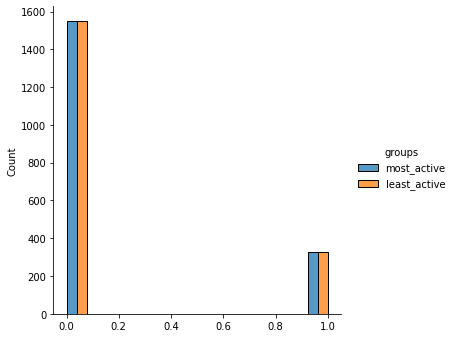

In [16]:
users = df['user_id'].unique()
np.random.seed(962)
first_half = np.random.choice(users, int(users.shape[0]/2), replace=False)
second_half = users[~np.isin(users, first_half)]

test_stream.unpaired_group_test(groups=(first_half, second_half),
                                function=lambda x: 'payment_done' in x['event_name'].values,
                                group_names=('most_active', 'least_active'),
                                test='fisher_exact',
                                plot_groups=True)

{'group_one_name': 'most_active',
 'group_one_size': 1875,
 'group_one_mean': 0.17333333333333334,
 'group_one_SD': 0.37853518844209044,
 'group_two_name': 'least_active',
 'group_two_size': 1876,
 'group_two_mean': 0.17484008528784648,
 'group_two_SD': 0.37983026454507945,
 'greatest_group_name': 'most_active',
 'is_group_one_greatest': True,
 'p_val': 0.4515904809904342,
 'power_estimated': 0.0638554853691331}

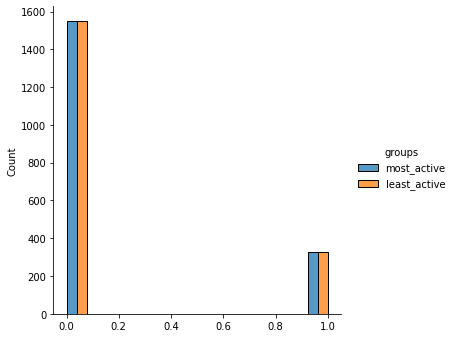

In [17]:
users = df['user_id'].unique()
np.random.seed(962)
first_half = np.random.choice(users, int(users.shape[0]/2), replace=False)
second_half = users[~np.isin(users, first_half)]

test_stream.unpaired_group_test(groups=(first_half, second_half),
                                function=lambda x: 'payment_done' in x['event_name'].values,
                                group_names=('most_active', 'least_active'),
                                test='ttest',
                                plot_groups=True)